In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from datetime import datetime
import tclab
import time
import os
from IPython.display import display, clear_output
from ipywidgets import interact,FloatSlider # use of slider and interactive plot update

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_DBR import *
from package_LAB import *

simulation params

In [8]:
# # Wrong DV response values
# #SOPDT PV in-out dynamics params
# Kp = 0.6738137025155853
# T1p = 183.44770757727215
# T2p = 5.327855225788805e-05
# thetap = 10.192078303908199

# #SOPDT DV disturbance dynamics params
# Kd = 1.7443694961231686
# T1d = 175.24005491030132
# T2d = 105.33387389061804
# thetad = 7.000129805865814

In [9]:
#SOPDT PV in-out dynamics params
Kp = 0.6738137025155853
T1p = 183.44770757727215
T2p = 5.327855225788805e-05
thetap = 10.192078303908199

#SOPDT DV disturbance dynamics params
Kd = 0.45188195989398117
T1d = 93.79714286404828
T2d = 47.79759461272312
thetad = 2.0000001555147313

In [10]:
# Optimised identification

# #MV SOPDT
# Final SSE Objective: 0.14336426277217823
# K: 0.6738137025155853
# T1: 183.44770757727215
# T2: 5.327855225788805e-05
# theta: 10.192078303908199


# #DV SOPDT
# Final SSE Objective: 0.0031928922557109864
# K: 0.45188195989398117
# T1: 93.79714286404828
# T2: 47.79759461272312
# theta: 2.0000001555147313

In [11]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 75
SPPath = {0:50, 5:50, 50:50, 80:50, TSim: 50}
MVPath = {0:1, 100:0, TSim:1}
#MVPath = {0:1, 100:0, TSim:1}

gamma = 0.6
Kc,Ti,Td = IMC_tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print(Kc,Ti,Td)
#Kc,Ti,Td = 1, 26.38, 5.142532221379834
Kc,Ti,Td = 3, 136, 9
alpha = 1
MVMin = 0
MVMax = 100

2.2638562103704953 183.4477608558244 5.327853678425066e-05


In [12]:

# # OLP + no FF
# ManPath = {0: True, TSim: True}               # Path for Man
# MVManPath = {0: MV0 , Tsim : MV0}             # path for MVMan
# SPPath = {0: PV0, TSim: MV0}                  # Path for SP, always the same in most cases
# DVPath = {0: 50.0, 1000: 60, TSim: 60.0}      # Path for DV
# ActivateFF = False
# ManFF = True

             
# ManPath = {0: True, TSim: True}               # Path for Man
# MVManPath = {0: MV0, TSim: MV0}               # Path for MVMan
# SPPath = {0: PV0, TSim: PV0}                  # Path for SP, always the same in most cases
# DVPath = {0: 50.0, 1000: 60,  TSim: 60.0}     # Path for DV
# ActivateFF = True
# ManFF = True

          
# # 4 :FF + CLP
# ManPath = {0: True, 750: False,  TSim: False}   # Path for Man
# MVManPath = {0: MV0+10, TSim: MV0+10}                 # Path for MVMan
# SPPath = {0: PV0+5,800:PV0-5, TSim: PV0-5}      # Path for SP, always the same in most cases
# DVPath = {0: DV0,2000: DV0+10, TSim: DV0+10}    # Path for DV
# ActivateFF = True
# ManFF= False

# #CLP_FF
title = "CLP_FF"  
ManPath = {0: True, 500: False,  TSim: False}   # Path for Man
MVManPath = {0: MV0+10, TSim: MV0+10}           # Path for MVMan
SPPath = {0: PV0+5,1200:PV0-5, TSim: PV0-5}     # Path for SP, always the same in most cases
DVPath = {0: DV0,2000: DV0+10, TSim: DV0+10}    # Path for DV
ActivateFF = True
ManFF= False

# ManPath = {0:True, 750: False, TSim: False}   # Path for Man
# MVManPath = {0: MV0, TSim: MV0}               # Path for MVMan
# SPPath = {0: PV0, 800:PV0-10, TSim: PV0-10}   # Path for SP, always the same in most cases
# DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10} # Path for DV
# ActivateFF = False
# ManFF= False


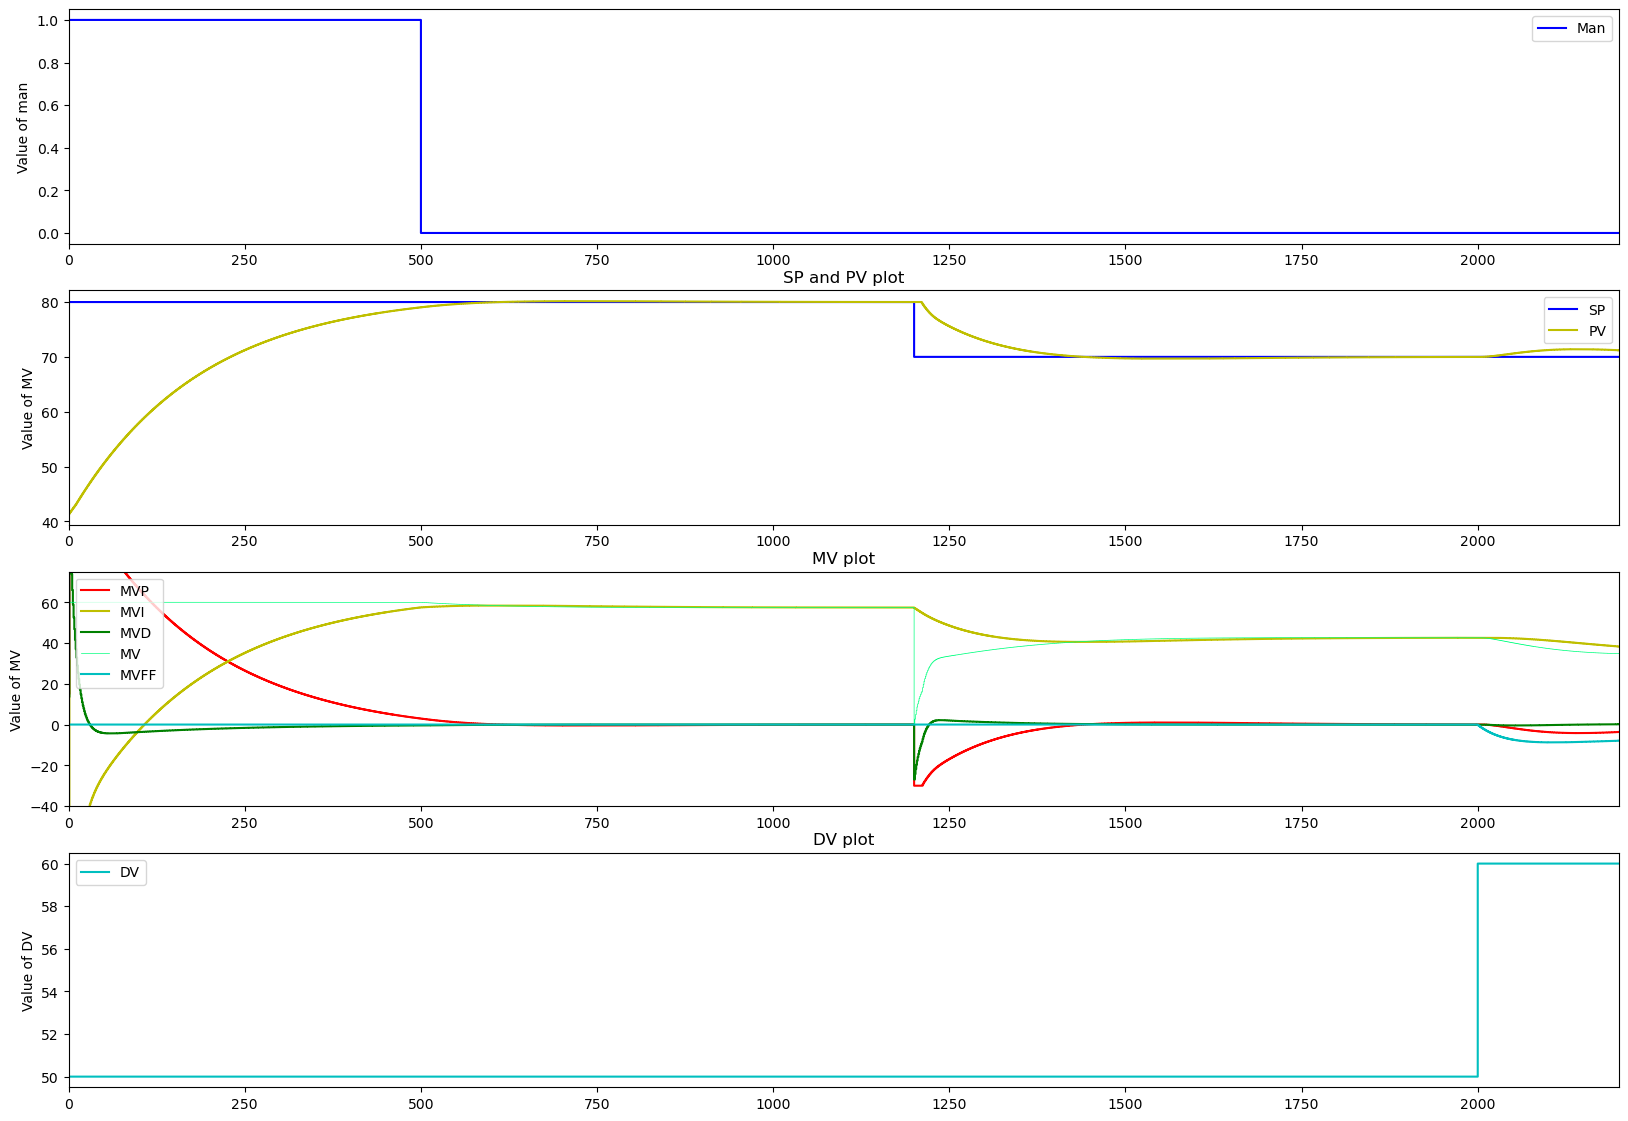

In [13]:
t = []
MVP=[]
MVI=[]
MVD=[]
DV = []
PV = []
SP = []
MV = []
E = []

MVFF = []
MVMan=[]
Man = []

MVFFDelay = []
MVFFLL = []

MVDelayp = []
MVDelayd = []

PV1p = []   #use in case of FF activation
PV2p = []

PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)
    
    # sp & dv
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # FeedForward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    Lead_Lag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL)
    Lead_Lag_RT(MVFFLL,int(ActivateFF),T2p,T2d,Ts,MVFF)
    
    # PID mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # pid
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    # Input-output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    # Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)

    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)
        
plt.figure(figsize = (20,14))

plt.subplot(4,1,1)
plt.step(t,Man,'b-',label='Man',where='post')
plt.ylabel('Value of man')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,2)
plt.step(t,SP,'b-',label='SP',where='post')
plt.step(t,PV,'y-',label='PV',where='post')
plt.ylabel('Value of MV')
plt.title('SP and PV plot')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,3)
plt.step(t,MVP,'r-',label='MVP',where='post')
plt.step(t,MVI,'y-',label='MVI',where='post')
plt.step(t,MVD,'g-',label='MVD',where='post')
plt.step(t,MV,'springgreen',linewidth=0.5,label='MV',where='post')
plt.step(t,MVFF,'c-',label='MVFF',where='post')
plt.ylabel('Value of MV')
plt.title('MV plot')
plt.legend(loc='best')
plt.xlim([0, TSim])
plt.ylim([-40, 75])

plt.subplot(4,1,4)
plt.step(t,DV,'c-',label='DV',where='post')
plt.ylabel('Value of DV')
plt.title('DV plot')
plt.legend(loc='best')
plt.xlim([0, TSim])
plt.show()
